In [57]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.nn.functional import mse_loss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import glob
from compute_distance import compute_distance
from scipy.spatial import cKDTree

In [58]:
weights_path = 'models/test'

h_n = 64
input_n = 4
n_layers = 8

ds = 0.4
dp = 0.1

folder_path = "data/unscaled_p"
model = 'best'

s = "0.6_10"
file_path_t = f"data/unscaled_p/TrP4_{s}.csv"
file_pat_t = f"results/test/csv/test_{s}.csv"

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# General PINN architecture for u, v, or p
class PINN(nn.Module):
    def __init__(self, input_dim=4, output_dim=1, hidden_dim=64, num_layers=8):
        super(PINN, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(Swish())

        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(Swish())

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [61]:
def initialize_models(model='best'):
    net_u = PINN(input_dim=input_n, output_dim=1, hidden_dim=h_n, num_layers=n_layers).to(device)
    net_v = PINN(input_dim=input_n, output_dim=1, hidden_dim=h_n, num_layers=n_layers).to(device)
    net_p = PINN(input_dim=input_n, output_dim=1, hidden_dim=h_n, num_layers=n_layers).to(device)

    def init_xavier(model):
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)  # or small constant like 1e-3

    net_u.apply(init_xavier)
    net_v.apply(init_xavier)
    net_p.apply(init_xavier)

    net_u.load_state_dict(torch.load(f"{weights_path}/{model}_u.pth"))
    net_v.load_state_dict(torch.load(f"{weights_path}/{model}_v.pth"))
    net_p.load_state_dict(torch.load(f"{weights_path}/{model}_p.pth"))

    return net_u, net_v, net_p

In [62]:
net_u, net_v, net_p, *_ = initialize_models(model)

# Define value ranges
first_values = np.arange(0.3, 0.7, 0.05)  # 0.25 to 0.7 with step 0.05
# second_values = np.arange(3, 15, 1)  # 3 to 14
second_values = [10]

# Iterate over all possible files
for first in first_values:
    for second in second_values:
        first_str = f"{first:.2f}".rstrip("0").rstrip(".")
        file_name = f"TrP4_{first_str}_{second}.csv"
        file_path = os.path.join(folder_path, file_name)
        
        if os.path.exists(file_path):
            print(f"Processing {file_name}...")
            
            # Load CSV file
            df = pd.read_csv(file_path)
            
            # Extract input and output data
            input_data = df.iloc[:, [0, 1, 5, 7]].values  # (x, y, d, N) [0, 1, 5, 7]
            output_data = df.iloc[:, [2, 3, 4]].values  # (u, v, p)
            
            input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
            x,y,d,n = input_tensor[:, 0], input_tensor[:, 1], input_tensor[:, 2], input_tensor[:, 3]
            
            # Predict using trained models
            with torch.no_grad():
                u_pred = net_u(input_tensor)
                v_pred = net_v(input_tensor)
                p_pred = net_p(input_tensor)

            # Apply conditions
            v_pred = v_pred.flatten()
            u_pred = u_pred.flatten()
            p_pred = p_pred.flatten()

            # distances = compute_distance(x, y, d, n, ds)

            # xStart = 0
            # xEnd = ds

            # u_pred = u_pred * distances
            # v_pred = v_pred * distances
            # p_pred = (xStart - x)*0 + dp * (xEnd - x) / ds + 0 * y + (xStart - x) * (xEnd - x) * p_pred

            # Prepare DataFrame for output
            df_output = pd.DataFrame({
                'x': input_data[:, 0],
                'y': input_data[:, 1],
                'u': u_pred.cpu().numpy(),
                'v': v_pred.cpu().numpy(),
                'p': p_pred.cpu().numpy()
            })
            
            # Save velocity output file
            output_file = f"test_{first_str}_{second}.csv"
            output_path = os.path.join(fr"results\test\csv", output_file)
            df_output.to_csv(output_path, index=False)
            print(f"Saved {output_file} successfully!")

print("Processing complete!")


Processing TrP4_0.3_10.csv...
Saved test_0.3_10.csv successfully!
Processing TrP4_0.35_10.csv...
Saved test_0.35_10.csv successfully!
Processing TrP4_0.4_10.csv...
Saved test_0.4_10.csv successfully!
Processing TrP4_0.45_10.csv...
Saved test_0.45_10.csv successfully!
Processing TrP4_0.5_10.csv...
Saved test_0.5_10.csv successfully!
Processing TrP4_0.55_10.csv...
Saved test_0.55_10.csv successfully!
Processing TrP4_0.6_10.csv...
Saved test_0.6_10.csv successfully!
Processing TrP4_0.65_10.csv...
Saved test_0.65_10.csv successfully!
Processing complete!


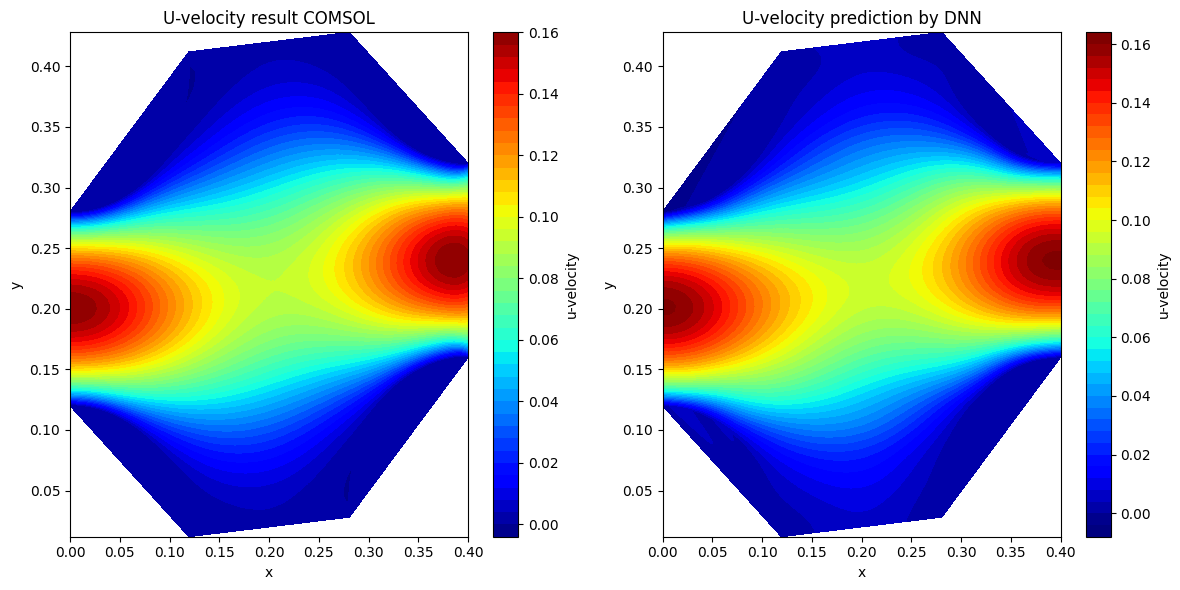

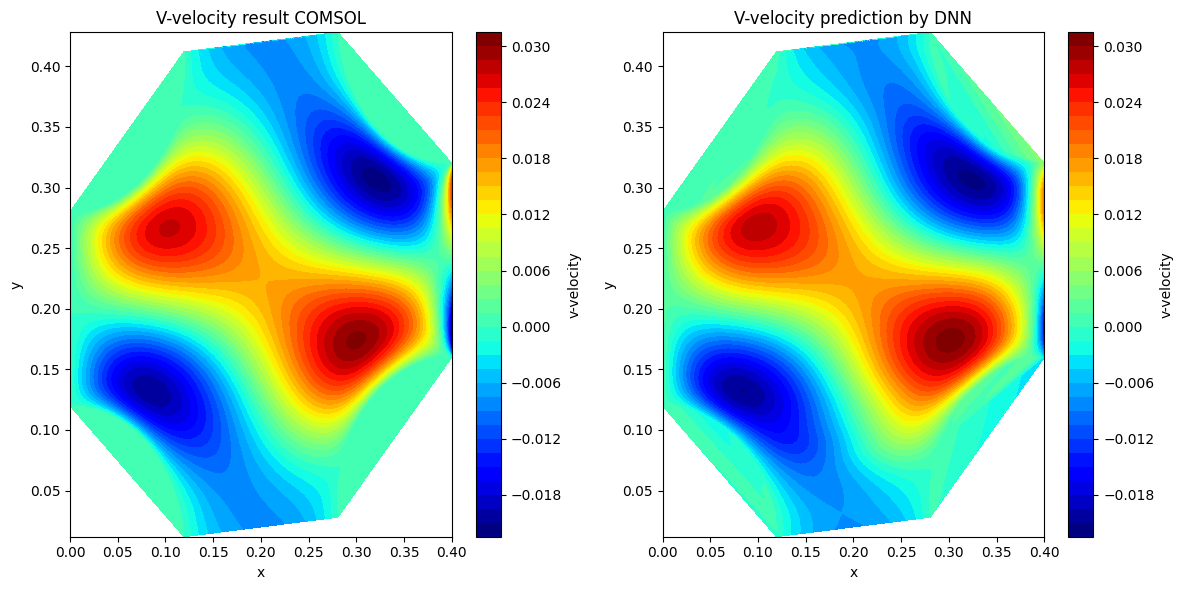

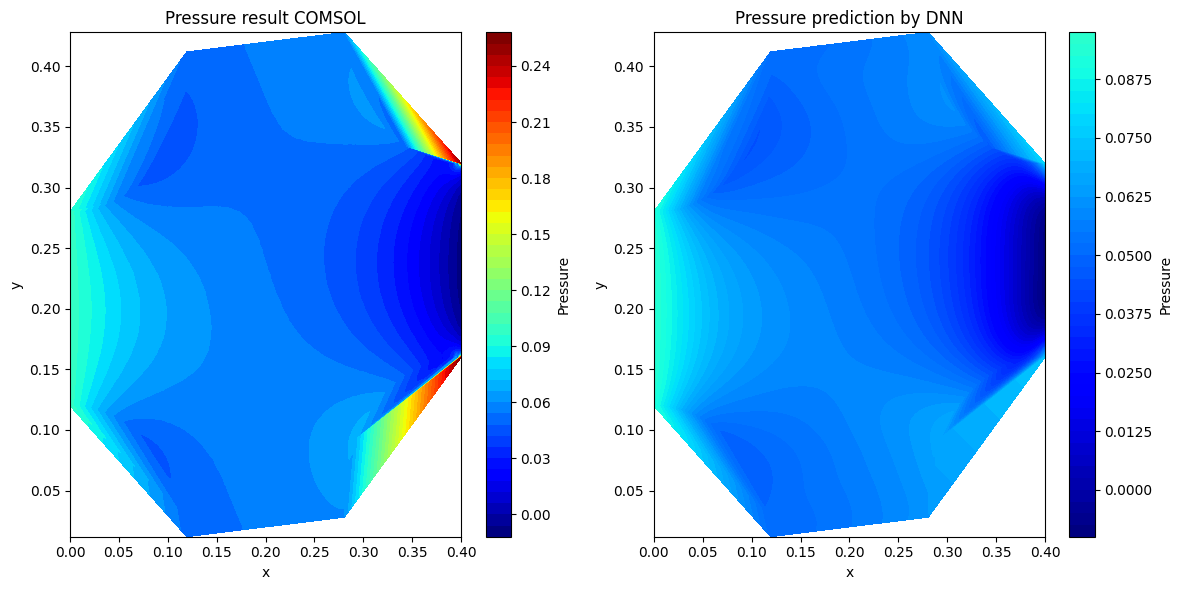

In [63]:
# %%
# Load CSV file
df = pd.read_csv(file_path_t)
dff = pd.read_csv(file_pat_t)

# Ensure the correct columns are selected for input
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d, N)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

# Ensure the correct columns are selected for input
input_dataf = dff.iloc[:, [0, 1]].values  # Selecting columns (x, y, d, N)
output_dataf = dff.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

x_grid = input_data[:, 0].reshape(-1)
y_grid = input_data[:, 1].reshape(-1)
v_actual_grid = output_data[:, 1].reshape(-1)
v_pred_grid = output_dataf[:, 1].reshape(-1)
u_actual_grid = output_data[:, 0].reshape(-1)
u_pred_grid = output_dataf[:, 0].reshape(-1)
p_actual_grid = output_data[:, 2].reshape(-1)
p_pred_grid = output_dataf[:, 2].reshape(-1)

# Determine the common range for colorbar
vmin = min(u_actual_grid.min(), u_pred_grid.min())
vmax = max(u_actual_grid.max(), u_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, u_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('U-velocity result COMSOL')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, u_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('U-velocity prediction by DNN')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/test/PIDNN_U_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v-velocity')
plt.title('V-velocity result COMSOL')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v-velocity')
plt.title('V-velocity prediction by DNN')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/test/PIDNN_V_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()

# Determine the common range for colorbar
vmin = min(p_actual_grid.min(), p_pred_grid.min())
vmax = max(p_actual_grid.max(), p_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual pressure
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, p_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='Pressure')
plt.title('Pressure result COMSOL')
plt.xlabel('x')
plt.ylabel('y')

# Predicted pressure
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, p_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='Pressure')
plt.title('Pressure prediction by DNN')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/test/PIDNN_P_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()


In [64]:
# Compute MSE using NumPy
mse_u = np.mean((v_pred_grid - v_actual_grid)**2)
print(f"Mean Squared Error for u-component: {mse_u}")

# Compute MSE using NumPy
mse_u = np.mean((u_pred_grid - u_actual_grid)**2)
print(f"Mean Squared Error for u-component: {mse_u}")

Mean Squared Error for u-component: 7.464278263920023e-07
Mean Squared Error for u-component: 5.582531595065216e-06
